# Analysis of the 2014 American Time Use Survey by Gregory Crowder
This Jupyter notebook does some very simple analysis of the 2014 ATUS data. [Download the data yourself](http://www.bls.gov/tus/datafiles_2014.htm) or clone my [atus-analysis repository](https://github.com/gcrowder/atus-analysis) on github to follow along.

The Bureau of Labor Statistics has spread the data across several disparate files. I will utilize three files in this notebook: Activity, Respondent, and Roster. These files can be linked by their common use of the TUCASEID variable, which the BLS has used to identify individual respondents to the survey.

The two main topics analyzed in this notebook are Child Care and Sleep.

### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import atus_analysis as at
%matplotlib inline

    import atus_analysis as at
[atus_analysis](https://github.com/gcrowder/atus-analysis/blob/master/atus_analysis.py) is a python module written to assist this notebook. It consists of three functions born out of refactoring the scratch version of this notebook.
We use its first function:
    read_in_data()
to read the three BLS data files into pandas DataFrames.

In [2]:
activity, respondent, roster = at.read_in_data()

## Child Care

We're interested in finding the average amount of time Americans spend providing child care every day. Extracting such an estimate from the ATUS data is possible but requires some wrangling due to the nature of data sample.

From Chapter 7: WEIGHTS, LINKING, AND ESTIMATION of the [American Time Use Survey User's Guide](http://www.bls.gov/tus/atususersguide.pdf).

>Users need to apply weights when computing estimates with the ATUS data because simple tabulations of unweighted ATUS data produce misleading results. These weights have already been calculated and are found on the Respondent file. Users may simply apply them when generating estimates.
The ATUS weights compensate for three important aspects of the sampling and data- collection process:

>* ATUS is based on a stratified random sample, whereby some demographic groups are oversampled to ensure adequate sample size for detailed estimates. The weights ensure that each group is correctly represented in the population.
* The ATUS sample is not uniformly distributed across the days of the week. About 25 percent of the sample is assigned to report on each of the 2 weekend days and 10 percent of the sample is assigned to each of the 5 weekdays. Hence, unweighted tabulations overestimate time spent in activities more often done on weekends and underestimate time spent in activities more often done on weekdays. The weights (variable TUFINLWGT) were constructed so that each day of the week is correctly represented for … the sample quarter (in 2005 and later).
* Response rates differ across demographic groups and days of the week. For example, men have lower response rates than do women, so the weights for male respondents are larger, on average, than those for female respondents. The weights ensure that groups and days of the week are correctly represented in spite of differing response rates.

TL;DR: You have to apply the provided pre-calculated weights to the variables in specific formulas (provided later in Chapter 7) if you want to make estimates about the "Average American."

The formula we need for the average amount of time Americans spend providing child care daily is:
\begin{equation}
\overline{T}_{j} = \frac{\sum{fwgt_{i}T_{ij}}}{\sum{fwgt_{i}}}
\end{equation}

where $T_{ij}$ is the amount of time spent in activity $j$ by respondent $i$, and $fwgt_{i}$ is the final weight for respondent i.

In [3]:
child_care = activity[['TUCASEID', 'TUACTIVITY_N', 'TUACTDUR24']].copy()
activity_codes = at.get_codes(activity) # This is re-used below in the Sleep code.
child_care['codes'] = activity_codes
child_care_by_ID = child_care.groupby(['TUCASEID'])
child_care_codes = ['0301', '0302', '0303']
child_care_time = pd.Series(at.get_minutes_subject(child_care_by_ID, child_care_codes), name='Child Care Time')

weight = respondent[['TUCASEID', 'TUFINLWGT', 'TRCHILDNUM', 'TRERNWA']].copy()
weight.set_index(weight.pop('TUCASEID'), inplace=True)
weighted_child_care = weight.join(child_care_time)
weighted_child_care['TRERNWA'] = weighted_child_care['TRERNWA'].replace(-1, 0)
weighted_child_care['TRERNWA'] = weighted_child_care['TRERNWA'] / 100
weighted_child_care['Weighted Care Time'] = weighted_child_care['TUFINLWGT'] * weighted_child_care['Child Care Time']
weighted_child_care = weighted_child_care.rename(columns={'TUFINLWGT': 'Weight',
                                                'TRCHILDNUM': 'Number of Children',
                                                'TRERNWA': 'Weekly Income'})

In [4]:
summed_child_care = weighted_child_care.sum()
child_care_avg_daily_minutes = summed_child_care['Weighted Care Time'] / summed_child_care['Weight']
child_care_hourly = child_care_avg_daily_minutes / 60

### Average hours spent per day by Americans on child care

In [5]:
child_care_hourly

0.41076853998861412

0.41 corresponds to the figure reported by the BLS in their table 1 from their [press release](http://www.bls.gov/news.release/archives/atus_06242015.htm) of the 2014 Survey.
![Hourly Child Care in the US](img/ATUS-Survey-hourly-childcare.png)
Hurray for accurate results!

### Graphing Child Care

Interestingly, time spent on child care seems to go down as number of children increases. However, there is no mathmatically negative correlation between the two variables.

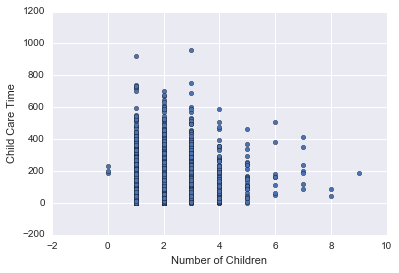

In [6]:
weighted_child_care.plot(kind='scatter', x='Number of Children', y='Child Care Time')

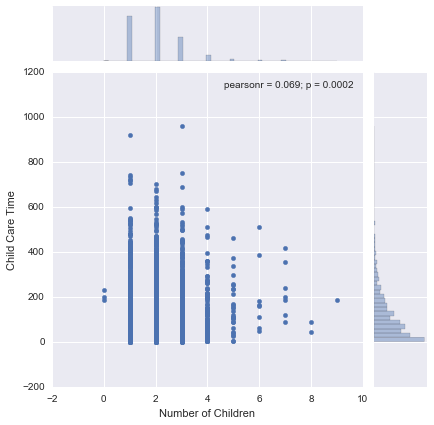

In [7]:
sns.jointplot(x="Number of Children", y='Child Care Time', data=weighted_child_care)

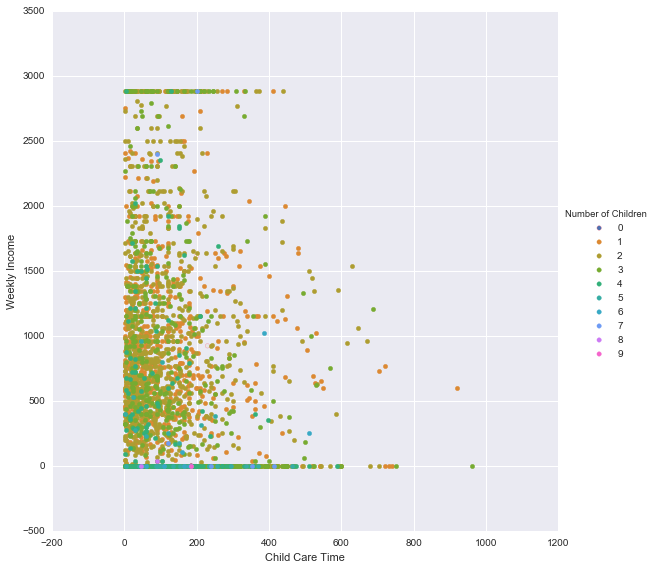

In [8]:
sns.FacetGrid(weighted_child_care, hue="Number of Children", size=8) \
   .map(plt.scatter, "Child Care Time", "Weekly Income") \
   .add_legend()

### Correlations: Not so much

Weekly Income and Number of Children are very weakly correlated. None of the other variables seem to have much relation to any other.

In [9]:
weighted_child_care.corr()

,Weight,Number of Children,Weekly Income,Child Care Time,Weighted Care Time
Weight,1.000000,-0.039614,-0.038998,-0.050574,0.466304
Number of Children,-0.039614,1.000000,0.111805,0.069178,0.090066
Weekly Income,-0.038998,0.111805,1.000000,-0.099774,-0.162361
Child Care Time,-0.050574,0.069178,-0.099774,1.000000,0.686949
Weighted Care Time,0.466304,0.090066,-0.162361,0.686949,1.000000


## Sleep

For the same reasons as Child Care we must apply the pre-calculated weights to the survey data in order to estimate the Average American's time spent sleeping. Thankfully, the formula is the same:
\begin{equation}
\overline{T}_{j} = \frac{\sum{fwgt_{i}T_{ij}}}{\sum{fwgt_{i}}}
\end{equation}

where $T_{ij}$ is the amount of time spent in activity $j$ by respondent $i$, and $fwgt_{i}$ is the final weight for respondent i.

For added graphing and correlation fun, we will utilize the Age and Sex data from the Roster file in our sleep DataFrame.

In [10]:
sleep = activity[['TUCASEID', 'TUACTIVITY_N', 'TUACTDUR24']].copy()
sleep['codes'] = activity_codes
sleep_by_ID = sleep.groupby(['TUCASEID'])

sleep_codes = ['010101', '010103']
sleeping_time = pd.Series(at.get_minutes_subject(sleep_by_ID, sleep_codes), name='Minutes Sleeping')
sleep_weight = respondent[['TUCASEID', 'TUFINLWGT', 'TRCHILDNUM', 'TRERNWA']].copy()
age_sex = pd.DataFrame.from_records([(row.TUCASEID, row.TEAGE, row.TESEX) for row in roster.itertuples() if row.TULINENO == 1], columns=['TUCASEID', 'Age', 'Sex'])

sleep_weight.set_index(sleep_weight.pop('TUCASEID'), inplace=True)
age_sex.set_index(age_sex.pop('TUCASEID'), inplace=True)
weighted_sleep = sleep_weight.join([age_sex, sleeping_time])

weighted_sleep['Weighted Minutes Sleeping'] = weighted_sleep['TUFINLWGT'] * weighted_sleep['Minutes Sleeping']
weighted_sleep['TRERNWA'] = weighted_sleep['TRERNWA'].replace(-1, 0)
weighted_sleep['TRERNWA'] = weighted_sleep['TRERNWA'] / 100
weighted_sleep['Sex'] = ['Male' if cell == 1 else 'Female' for cell in weighted_sleep['Sex']]
weighted_sleep = weighted_sleep.rename(columns={'TUFINLWGT': 'Weight',
                                                'TRCHILDNUM': 'Number of Children',
                                                'TRERNWA': 'Weekly Income'})

In [11]:
summed_sleep = weighted_sleep.sum()
average_sleep_minutes = summed_sleep['Weighted Minutes Sleeping'] / summed_sleep['Weight']
average_sleep_hour = average_sleep_minutes / 60

### Average hours spend per day by Americans on sleep

In [12]:
average_sleep_hour

8.738657264730689

Happily, this calculation too hits the mark. BLS puts hours of sleep per day at 8.80. Table 1 of [press release](http://www.bls.gov/news.release/archives/atus_06242015.htm) of the 2014 Survey.
![Average hours of sleep](img/ATUS-Survey-hourly-sleep.png)

### Graphing Sleep

Age doesn't determine sleep but number of kids seems to have an impact.

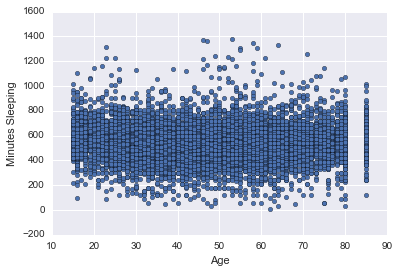

In [13]:
weighted_sleep.plot(kind='scatter', x='Age', y='Minutes Sleeping')

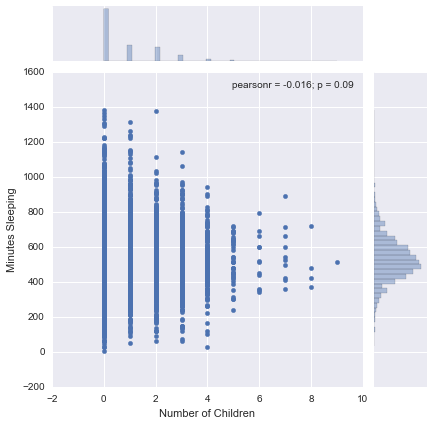

In [14]:
sns.jointplot(x='Number of Children', y='Minutes Sleeping', data=weighted_sleep)

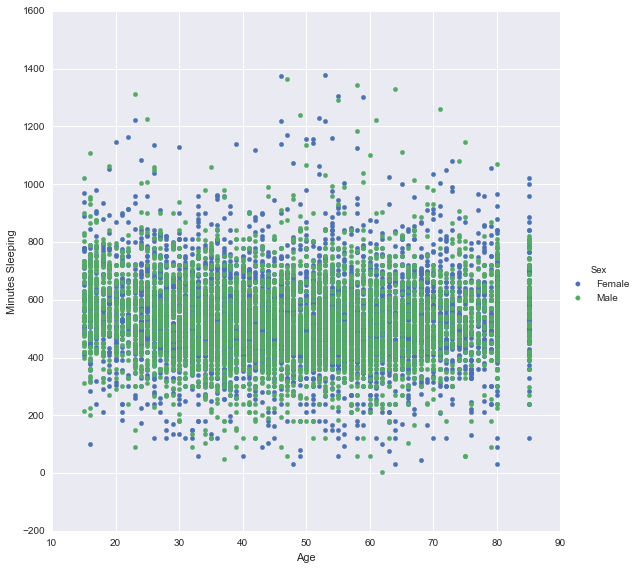

In [17]:
sns.FacetGrid(weighted_sleep, hue="Sex", size=8) \
   .map(plt.scatter, "Age", "Minutes Sleeping") \
   .add_legend()

### Correlations

Number of children is still weakly correlated to Weekly Income.
Age is also weekly correlated to Weekly Income.
Further, Age, unsurprisingly, has a strong negative correlation to children under 18 residing in the household.

In [16]:
weighted_sleep.corr()

,Weight,Number of Children,Weekly Income,Age,Minutes Sleeping,Weighted Minutes Sleeping
Weight,1.000000,-0.039614,-0.038998,-0.213174,-0.043805,0.939580
Number of Children,-0.039614,1.000000,0.111805,-0.465020,-0.015738,-0.035552
Weekly Income,-0.038998,0.111805,1.000000,-0.185745,-0.135006,-0.079839
Age,-0.213174,-0.465020,-0.185745,1.000000,-0.039077,-0.217973
Minutes Sleeping,-0.043805,-0.015738,-0.135006,-0.039077,1.000000,0.215317
Weighted Minutes Sleeping,0.939580,-0.035552,-0.079839,-0.217973,0.215317,1.000000


# Go forth and analyze

Download the data and let me know what you find.